In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle
from pathlib import Path
from importlib import reload
from IPython.display import clear_output

from IEFC_modules import iefc_functions

from roman_cgi_iefc import cgi, iefc_sim
import misc

import proper
proper.prop_use_fftw(DISABLE=False)
proper.prop_fftw_wisdom( 1024 ) 

data_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')

wavelength_c = 575e-9*u.m

wavelength_ref = 0.5e-6*u.m
pixelscale_lamD_ref = 1/2
pixelscale_ref = 13e-6*u.m/u.pix
pixelscale_lamD = pixelscale_lamD_ref * (wavelength_ref/wavelength_c)

wavelength = 575e-9*u.m
npsf = 64
psf_pixelscale = 13e-6*u.m/u.pix
psf_pixelscale_lamD = pixelscale_lamD * (psf_pixelscale/pixelscale_ref)
print(psf_pixelscale_lamD)

flatmaps_dir = Path.home()/'src/pyfalco/roman/flatmaps'

dm1_flatmap = fits.getdata(flatmaps_dir/'dm1_m_flat_hlc_band1.fits')
dm2_flatmap = fits.getdata(flatmaps_dir/'dm2_m_flat_hlc_band1.fits')
dm1_design = fits.getdata(flatmaps_dir/'dm1_m_design_hlc_band1.fits')
dm2_design = fits.getdata(flatmaps_dir/'dm2_m_design_hlc_band1.fits')

Computing wisdom for 8 threads
Computing wisdom for 1 threads
0.43478260869565216


Lambda = 5.7500E-07   Throughput = 1.00
Applying lens
Propagating to secondary
Applying lens
Propagating to POMA FOLD
Propagating to M3
Applying lens
Propagating to M4
Applying lens
Propagating to M5
Applying lens
Propagating to TT FOLD
Propagating to FSM
Propagating to OAP1
Applying lens
Propagating to FOCM
Propagating to OAP2
Applying lens
Propagating to DM1
Propagating to DM2
Propagating to OAP3
Applying lens
Propagating to FOLD_3
Propagating to OAP4
Applying lens
Propagating to PUPIL_MASK
Propagating to OAP5
Applying lens
Propagating to FPM
Propagating to OAP6
Applying lens
Propagating to LYOT STOP
Propagating to OAP7
Applying lens
Propagating to FIELD_STOP
Propagating to OAP8
Applying lens
Propagating to filter
Propagating to IMAGING LENS
Applying lens at IMAGING LENS lens #1
Propagating
Applying lens at IMAGING LENS lens #2
Propagating to IMAGE
Total elapsed time (seconds) =   8.4588


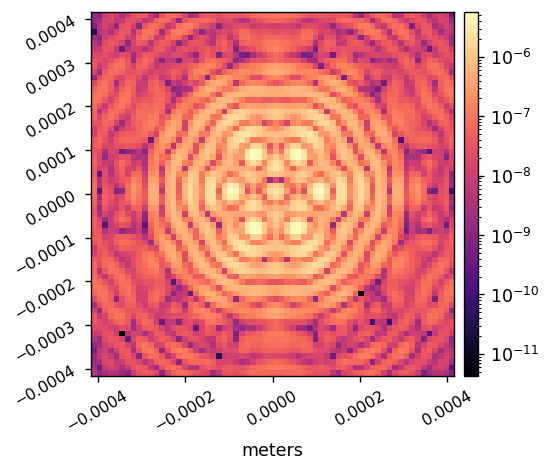

In [2]:
reload(cgi)

hlci = cgi.CGI_PROPER(use_opds=False, use_fieldstop=False, quiet=False)
# hlci.set_dm1(dm1_flatmap)
# hlci.set_dm2(dm2_flatmap)

psf = hlci.calc_psf()

misc.myimshow(psf, lognorm=True, pxscl=hlci.psf_pixelscale)

# Create dark hole ROI to calibrate and control

(4096,) (4096,) (4096,) (4096,)


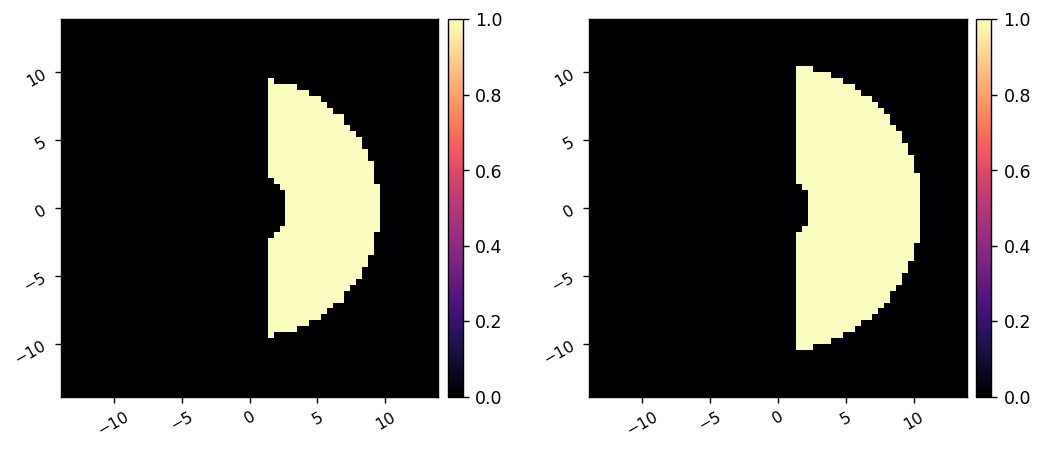

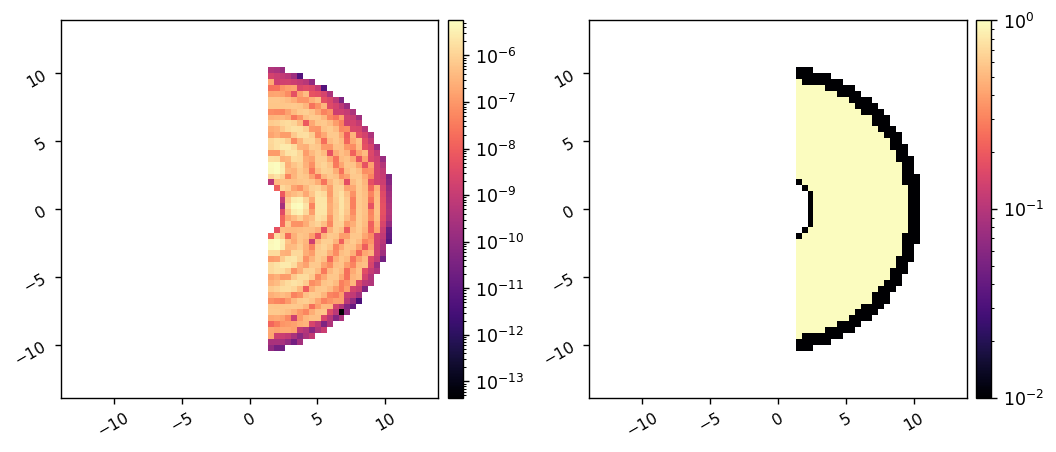

In [3]:
reload(iefc_sim)
xfp = np.linspace(-0.5, 0.5, npsf) * npsf * psf_pixelscale_lamD
xf,yf = np.meshgrid(xfp,xfp)

edge = 1.5
iwa = 2.8
owa = 9.7

# Create the mask that is used to select which region to make dark.
dh_params = {
    'inner_radius' : iwa,
    'outer_radius' : owa,
    'edge_position' : edge,
    'direction' : '+x'
}
dh_mask = iefc_sim.create_dshaped_focal_plane_mask(xf, yf, dh_params).ravel()

#Create the mask that is used to select which region to make dark.
control_params = {
    'inner_radius' : iwa-0.5,
    'outer_radius' : owa+1,
    'edge_position' : edge,
    'direction' : '+x'
}
control_mask = iefc_sim.create_dshaped_focal_plane_mask(xf, yf, control_params).ravel()

relative_weight = 0.99
weights = dh_mask * relative_weight + (1 - relative_weight) * control_mask

print(dh_mask.shape, control_mask.shape, control_mask.shape, weights.shape)
misc.myimshow2(dh_mask.reshape(npsf,npsf), control_mask.reshape(npsf,npsf), 
               pxscl1=psf_pixelscale_lamD, pxscl2=psf_pixelscale_lamD)
misc.myimshow2(psf*weights.reshape(npsf,npsf), weights.reshape(npsf,npsf), lognorm1=True, lognorm2=True,
               pxscl1=psf_pixelscale_lamD, pxscl2=psf_pixelscale_lamD)

# Create probe and fourier modes

Creating Fourier modes:  (64, 64)
(326, 2304) (2, 2304)


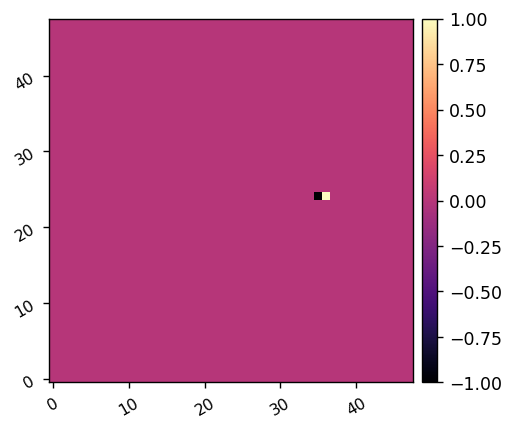

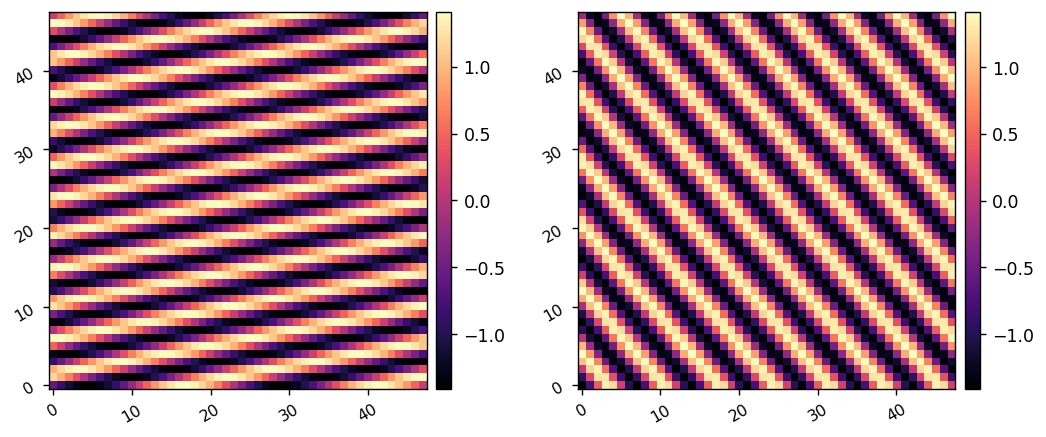

In [8]:
reload(iefc_sim)

Nact = hlci.Nact

fourier_modes, fx, fy = iefc_sim.create_fourier_modes(xfp, control_mask.reshape((npsf,npsf)), Nact, circular_mask=False)
probe_modes = iefc_sim.create_probe_poke_modes(hlci.Nact, 3*Nact//4, Nact//2, 3*Nact//4-1, Nact//2)

probe_amplitude = 0.05 * wavelength.to(u.m).value
calibration_amplitude = 0.006 * wavelength.to(u.m).value

print(fourier_modes.shape, probe_modes.shape)
misc.myimshow((probe_modes[0] - probe_modes[1]).reshape((Nact,Nact)))
misc.myimshow2(fourier_modes[0].reshape((Nact,Nact)), fourier_modes[300].reshape((Nact,Nact)))

# Testing

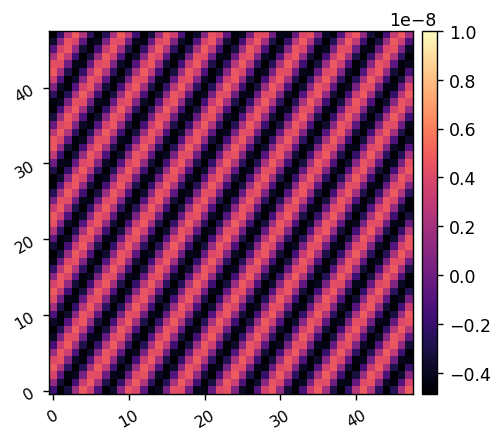

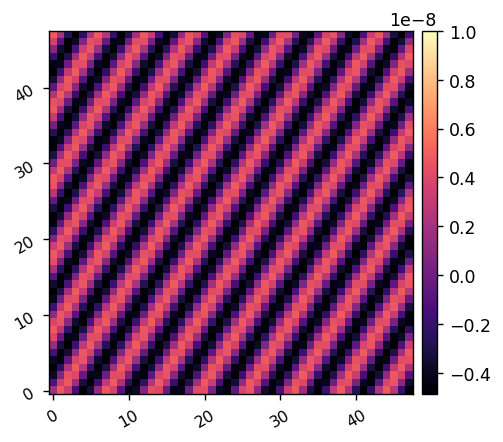

(2, 4096) (4, 4096)


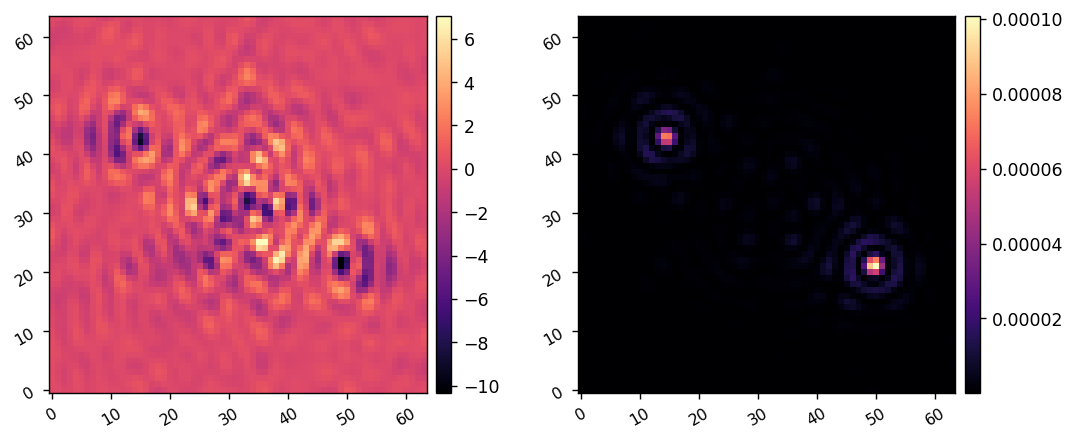

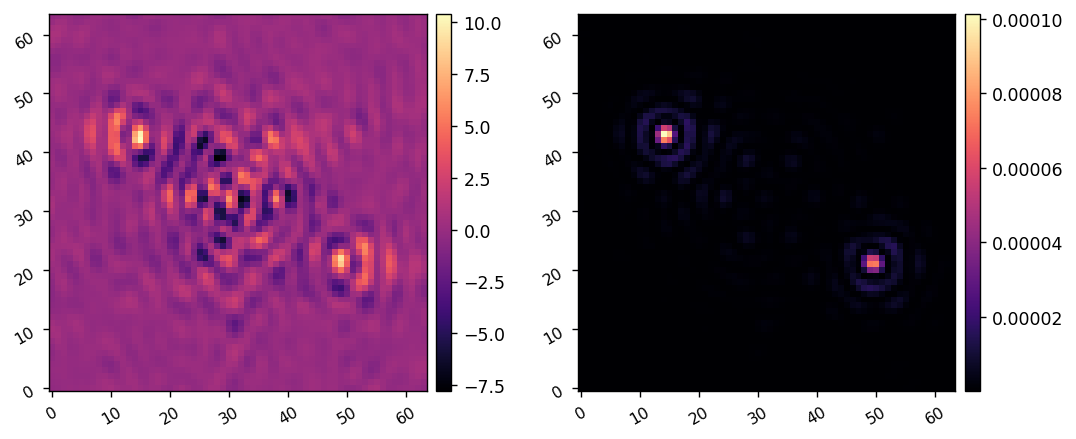

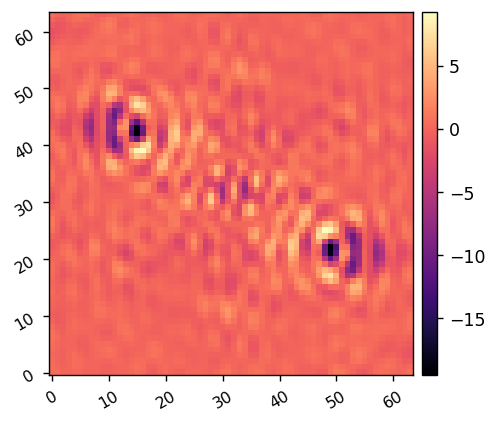

In [9]:
reload(iefc_sim)

hlci.add_dm1(calibration_amplitude * fourier_modes[200])
misc.myimshow(hlci.DM1, vmax=1e-8)
differential_images, single_images = iefc_sim.take_measurement(hlci, probe_modes, probe_amplitude, return_all=True)

hlci.add_dm1(-calibration_amplitude * fourier_modes[200]) # remove the previous DM setting

hlci.add_dm1(-calibration_amplitude * fourier_modes[200])
misc.myimshow(hlci.DM1, vmax=1e-8)
differential_images_2, single_images_2 = iefc_sim.take_measurement(hlci, probe_modes, probe_amplitude, return_all=True)

print(differential_images.shape, single_images.shape)
misc.myimshow2(differential_images[1].reshape((64,64)), single_images[3].reshape((64,64)))
misc.myimshow2(differential_images_2[1].reshape((64,64)), single_images_2[3].reshape((64,64)))
misc.myimshow((differential_images[1]-differential_images_2[1]).reshape(npsf,npsf))

In [1]:
326*22/3600

1.9922222222222221

# Calibrate IEFC (or load in previous calibration data)

In [ ]:
reload(iefc_sim)

response_cube, calibration_cube = iefc_sim.calibrate(hlci, probe_amplitude, probe_modes, 
                                                     calibration_amplitude, fourier_modes, start_mode=0)

Calibrating I-EFC...
	Calibrated mode 1 / 326 in 22.868s
	Calibrated mode 2 / 326 in 45.835s


In [24]:
print(response_cube.shape, calibration_cube.shape)

response_hdu = fits.PrimaryHDU(data=response_cube)
response_hdu.writeto(data_dir/'response-data'/'hlc_response_cube_ann_mask.fits', overwrite=True)

calib_hdu = fits.PrimaryHDU(data=calibration_cube)
calib_hdu.writeto(data_dir/'calibration-data'/'hlc_calibration_cube_ann_mask.fits', overwrite=True)

(300, 2, 4096) (600, 4, 4096)


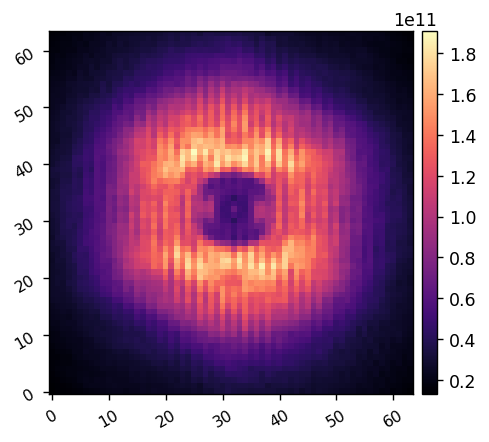

In [5]:
im = np.sum(abs(response_cube), axis=(0,1))
misc.myimshow(im.reshape(64,64))